## 📓 MNIST Digit Recognition

### INSTALL AND IMPORT LIBRARIES

In [3]:
# CNN
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Saving models
import joblib

# For data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For custom image prediction
import cv2

### Load MNIST Dataset

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (60000, 28, 28)
Test data shape: (10000, 28, 28)


### Visualize Sample Digits

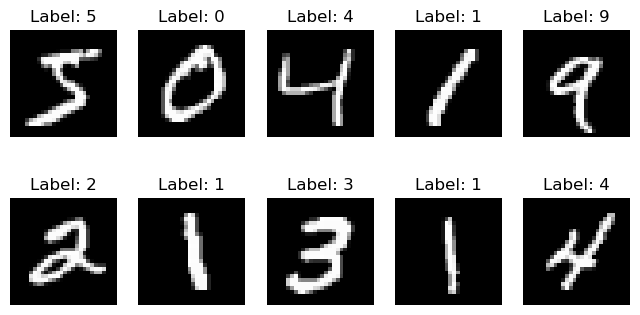

In [9]:
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i], cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.show()

### Preprocessing for CNN

In [12]:
X_train_cnn = X_train.astype('float32') / 255.0
X_test_cnn = X_test.astype('float32') / 255.0

X_train_cnn = np.expand_dims(X_train_cnn, -1)
X_test_cnn = np.expand_dims(X_test_cnn, -1)

y_train_cnn = to_categorical(y_train, 10)
y_test_cnn = to_categorical(y_test, 10)

### Build CNN Model

In [15]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### Train CNN (Without Augmentation)

In [18]:
history = model.fit(
    X_train_cnn, y_train_cnn,
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=5,
    batch_size=128,
    verbose=2
)

Epoch 1/5
469/469 - 8s - 18ms/step - accuracy: 0.9066 - loss: 0.3078 - val_accuracy: 0.9780 - val_loss: 0.0642
Epoch 2/5
469/469 - 8s - 17ms/step - accuracy: 0.9699 - loss: 0.1002 - val_accuracy: 0.9864 - val_loss: 0.0428
Epoch 3/5
469/469 - 8s - 17ms/step - accuracy: 0.9775 - loss: 0.0742 - val_accuracy: 0.9882 - val_loss: 0.0360
Epoch 4/5
469/469 - 8s - 18ms/step - accuracy: 0.9816 - loss: 0.0603 - val_accuracy: 0.9892 - val_loss: 0.0333
Epoch 5/5
469/469 - 8s - 18ms/step - accuracy: 0.9852 - loss: 0.0502 - val_accuracy: 0.9896 - val_loss: 0.0311


### Evaluate CNN

In [21]:
loss, acc = model.evaluate(X_test_cnn, y_test_cnn)
print(f"CNN Test Accuracy (No Augmentation): {acc*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9881 - loss: 0.0366
CNN Test Accuracy (No Augmentation): 98.96%


### Preprocessing for Random Forest

In [24]:
X_train_rf = X_train.reshape(X_train.shape[0], -1) / 255.0
X_test_rf = X_test.reshape(X_test.shape[0], -1) / 255.0

### Train Random Forest

In [27]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_rf, y_train)

y_pred_rf = rf.predict(X_test_rf)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf)*100:.2f}%")

Random Forest Accuracy: 96.92%


### Compare Results

In [30]:
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.98      0.97      0.97       982
           5       0.97      0.96      0.97       892
           6       0.98      0.97      0.98       958
           7       0.97      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



### Plot CNN Training History

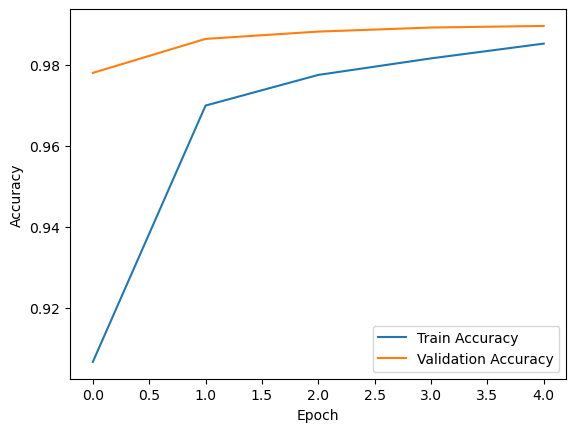

In [33]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Save Trained Models

In [38]:
model.save("mnist_cnn_model.h5")
print("✅ CNN model saved as mnist_cnn_model.h5")

joblib.dump(rf, "mnist_rf_model.pkl")
print("✅ Random Forest model saved as mnist_rf_model.pkl")

✅ CNN model saved as mnist_cnn_model.h5
✅ Random Forest model saved as mnist_rf_model.pkl


### Load Models

In [41]:
cnn_loaded = load_model("mnist_cnn_model.h5")
print("✅ CNN model loaded")

rf_loaded = joblib.load("mnist_rf_model.pkl")
print("✅ Random Forest model loaded")

✅ CNN model loaded
✅ Random Forest model loaded


### Predict on a Custom Image

In [63]:
# Load external digit image (ensure it's 28x28 grayscale)
img = cv2.imread("my_digit.png", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (28, 28))

# Invert if necessary
if np.mean(img) > 127:
    img = 255 - img

# CNN prediction
img_cnn = img.astype('float32') / 255.0
img_cnn = np.expand_dims(img_cnn, axis=(0, -1))
pred_cnn = np.argmax(cnn_loaded.predict(img_cnn))
print(f"🖥 CNN Prediction: {pred_cnn}")

# Random Forest prediction
img_rf = img.reshape(1, -1) / 255.0
pred_rf = rf_loaded.predict(img_rf)[0]
print(f"🌲 Random Forest Prediction: {pred_rf}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
🖥 CNN Prediction: 3
🌲 Random Forest Prediction: 3


In [65]:
# Load external digit image (ensure it's 28x28 grayscale)
img = cv2.imread("my_digit1.png", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (28, 28))

# Invert if necessary
if np.mean(img) > 127:
    img = 255 - img

# CNN prediction
img_cnn = img.astype('float32') / 255.0
img_cnn = np.expand_dims(img_cnn, axis=(0, -1))
pred_cnn = np.argmax(cnn_loaded.predict(img_cnn))
print(f"🖥 CNN Prediction: {pred_cnn}")

# Random Forest prediction
img_rf = img.reshape(1, -1) / 255.0
pred_rf = rf_loaded.predict(img_rf)[0]
print(f"🌲 Random Forest Prediction: {pred_rf}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
🖥 CNN Prediction: 9
🌲 Random Forest Prediction: 5


### Show Misclassified Digits

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


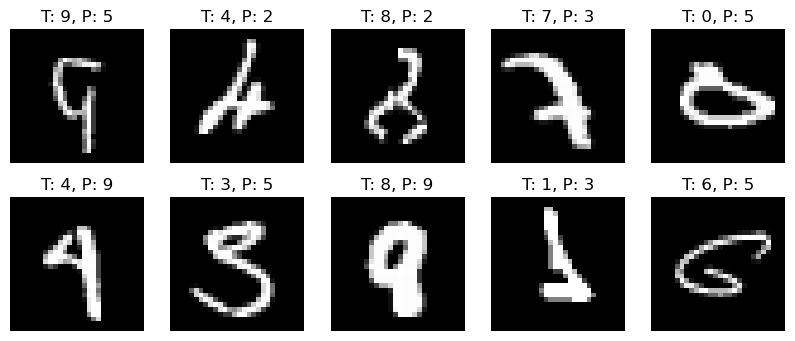

In [68]:
cnn_preds = np.argmax(cnn_loaded.predict(X_test_cnn), axis=1)
misclassified_idx = np.where(cnn_preds != y_test)[0]

plt.figure(figsize=(10, 4))
for i, idx in enumerate(misclassified_idx[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[idx], cmap='gray')
    plt.title(f"T: {y_test[idx]}, P: {cnn_preds[idx]}")
    plt.axis('off')
plt.show()

### Data Augmentation

In [71]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train_cnn)

### Train CNN with Augmentation

In [74]:
history_aug = model.fit(
    datagen.flow(X_train_cnn, y_train_cnn, batch_size=128),
    validation_data=(X_test_cnn, y_test_cnn),
    epochs=5,
    verbose=2
)

Epoch 1/5


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


469/469 - 9s - 19ms/step - accuracy: 0.9400 - loss: 0.1971 - val_accuracy: 0.9910 - val_loss: 0.0278
Epoch 2/5
469/469 - 9s - 19ms/step - accuracy: 0.9637 - loss: 0.1243 - val_accuracy: 0.9918 - val_loss: 0.0233
Epoch 3/5
469/469 - 9s - 18ms/step - accuracy: 0.9698 - loss: 0.1031 - val_accuracy: 0.9926 - val_loss: 0.0216
Epoch 4/5
469/469 - 8s - 18ms/step - accuracy: 0.9736 - loss: 0.0884 - val_accuracy: 0.9926 - val_loss: 0.0227
Epoch 5/5
469/469 - 9s - 18ms/step - accuracy: 0.9755 - loss: 0.0838 - val_accuracy: 0.9924 - val_loss: 0.0219


### Evaluate Augmented Model

In [77]:
loss_aug, acc_aug = model.evaluate(X_test_cnn, y_test_cnn)
print(f"Accuracy without Augmentation: {acc*100:.2f}%")
print(f"Accuracy with Augmentation: {acc_aug*100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9901 - loss: 0.0249
Accuracy without Augmentation: 98.96%
Accuracy with Augmentation: 99.24%


### Visualize Augmented Images

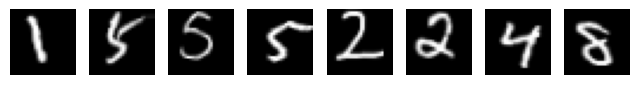

In [80]:
augmented_images, _ = next(datagen.flow(X_train_cnn, y_train_cnn, batch_size=8))

plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i+1)
    plt.imshow(augmented_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

## Summary

In [83]:
print("""
🔹 CNN outperforms Random Forest because it learns spatial patterns in images.
🔹 Random Forest loses spatial information when flattening.
🔹 Data Augmentation improves generalization by simulating variations.
🔹 Saving and loading models makes deployment easier.
🔹 Error analysis reveals tricky cases for further improvement.
""")


🔹 CNN outperforms Random Forest because it learns spatial patterns in images.
🔹 Random Forest loses spatial information when flattening.
🔹 Data Augmentation improves generalization by simulating variations.
🔹 Saving and loading models makes deployment easier.
🔹 Error analysis reveals tricky cases for further improvement.

